In [1]:
!pip uninstall tensorflow -y

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0


In [2]:
!pip install tensorflow==2.15.0

  Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.


In [3]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [4]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
import numpy as np
import os
import matplotlib.pyplot as plt
import pathlib
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau



In [7]:
data_dir = pathlib.Path("/content/drive/MyDrive/Dataset_full/ds_train")
print(data_dir)
data_teste = pathlib.Path("/content/drive/MyDrive/Dataset_full/ds_test")
print(data_teste)

/content/drive/MyDrive/Dataset_full/ds_train
/content/drive/MyDrive/Dataset_full/ds_test


In [8]:
np.random.seed(1000)

image_shape = 227
batch_size = 100
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(image_shape,image_shape,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(image_shape,image_shape,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(5))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))


# Resumo do modelo
AlexNet.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 57, 57, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 57, 57, 96)        384       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 57, 57, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 29, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 29, 29, 256)       1

In [9]:
AlexNet.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="training",
    seed=123,
    label_mode="categorical",
    image_size=(image_shape, image_shape),
    batch_size=batch_size
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(image_shape,image_shape),
    batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_teste,
    seed=123,
    label_mode="categorical",
    image_size=(image_shape,image_shape),
    batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 43028 files belonging to 5 classes.
Using 38726 files for training.
Found 43028 files belonging to 5 classes.
Using 4302 files for validation.
Found 4779 files belonging to 5 classes.
['basal_cell_carcinoma', 'melanoma', 'nevus', 'seborrheic_keratosis', 'squamous_cell_carcinoma']


In [11]:
for image_batch, labels_batch in train_ds:
  train_img = image_batch
  train_labels = labels_batch
  break
for image_batch, labels_batch in val_ds:
  val_img = image_batch
  val_labels = labels_batch
  break
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  test_img = image_batch
  test_labels = labels_batch
  break

(100, 227, 227, 3)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
epochs = 50



history = AlexNet.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
    )

Epoch 1/50
388/388 [==============================] - 526s 372ms/step - loss: 1.1120 - accuracy: 0.6969 - val_loss: 2.3756 - val_accuracy: 0.4007
Epoch 2/50
388/388 [==============================] - 17s 43ms/step - loss: 0.8436 - accuracy: 0.7550 - val_loss: 0.8363 - val_accuracy: 0.7387
Epoch 3/50
388/388 [==============================] - 17s 43ms/step - loss: 0.7240 - accuracy: 0.7722 - val_loss: 2.2961 - val_accuracy: 0.4577
Epoch 4/50
388/388 [==============================] - 17s 44ms/step - loss: 0.6539 - accuracy: 0.7811 - val_loss: 0.7248 - val_accuracy: 0.7624
Epoch 5/50
388/388 [==============================] - 17s 44ms/step - loss: 0.6032 - accuracy: 0.7941 - val_loss: 0.6944 - val_accuracy: 0.7543
Epoch 6/50
388/388 [==============================] - 17s 44ms/step - loss: 0.5619 - accuracy: 0.8023 - val_loss: 0.6859 - val_accuracy: 0.7478
Epoch 7/50
388/388 [==============================] - 17s 44ms/step - loss: 0.5237 - accuracy: 0.8131 - val_loss: 0.7645 - val_accurac

In [14]:
loss, acc = AlexNet.evaluate(test_ds)
print("Accuracy", acc)

48/48 [==============================] - 153s 3s/step - loss: 1.5873 - accuracy: 0.7698
Accuracy 0.769826352596283


In [15]:
# prompt: print the classification report
import numpy as np
from sklearn.metrics import classification_report


# Get predictions for the test set
y_pred = AlexNet.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)


y_true = tf.concat([y for x, y in test_ds], axis=0).numpy()
# Convert y_true to class indices
y_true_classes = np.argmax(y_true, axis=1)

# Print the classification report
print(classification_report(y_true_classes, y_pred_classes))


48/48 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0       0.65      0.35      0.46       477
           1       0.79      0.39      0.52       722
           2       0.79      0.99      0.88      3260
           3       0.23      0.03      0.05       190
           4       0.19      0.08      0.12       130

    accuracy                           0.77      4779
   macro avg       0.53      0.37      0.40      4779
weighted avg       0.74      0.77      0.73      4779



In [16]:
y_pred=np.argmax(AlexNet.predict(test_img), axis=-1)

# Convert test_labels to class indices
test_labels = np.argmax(test_labels, axis=1)

con_mat = tf.math.confusion_matrix(labels=test_labels, predictions=y_pred).numpy()



4/4 [==============================] - 1s 82ms/step


48/48 [==============================] - 1s 20ms/step


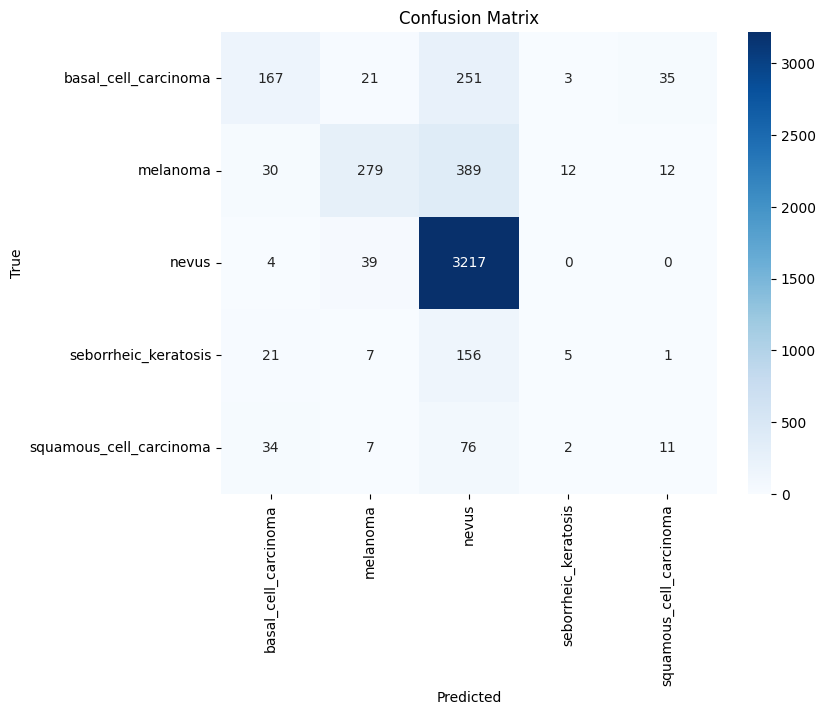

In [17]:
# prompt: imprima a matriz confusao do modelo acima

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for the test set
y_pred = AlexNet.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test set
y_true = tf.concat([y for x, y in test_ds], axis=0).numpy()
y_true_classes = np.argmax(y_true, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

48/48 [==============================] - 1s 20ms/step


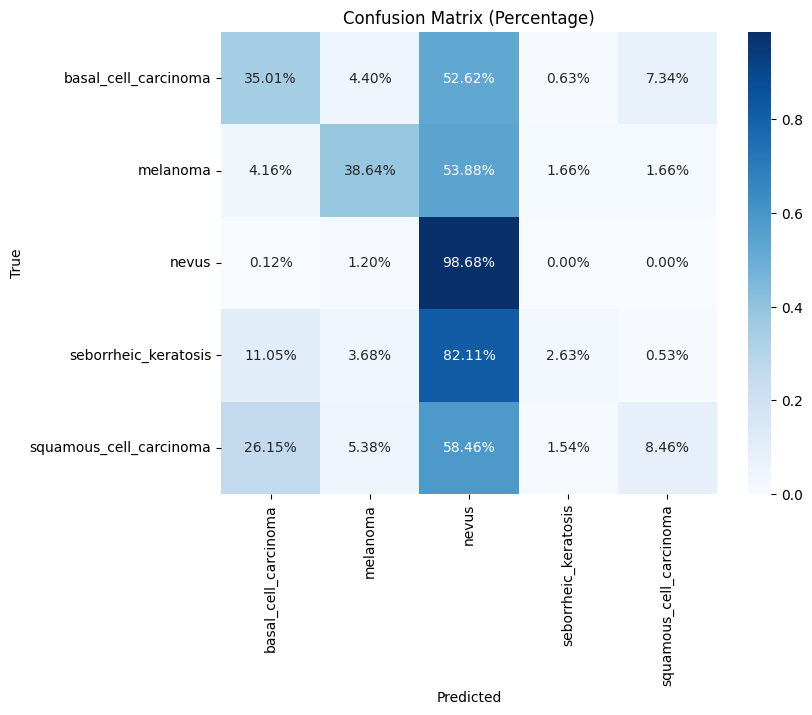

In [18]:
# prompt: gere uma matriz de confusão do treinamento acima mas com porcentagem

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions for the test set
y_pred = AlexNet.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test set
y_true = tf.concat([y for x, y in test_ds], axis=0).numpy()
y_true_classes = np.argmax(y_true, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix to get percentages
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix using seaborn with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentage)')
plt.show()
